**Read image from disk**

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

im_path = 'E:/Peter/Scheme/scheme_copy/scheme_007.png'
image = np.array(Image.open(im_path))
image_copy = image.copy()
%matplotlib inline

In [6]:
len(image[image < 1])

53397

**Functions**

In [7]:
def generate_separation_coordinates(image_shape, resulting_image_shape, overlap_shape):
    """Generates coordinates for image separation.
    
    Makes coordinates for overlapped image separion using given image shape.
    
    Args:
        image_shape: a tuple containing image width and height.
        resulting_image_shape: a tuple containing output image shape.
        overlap_shape: a tuple containing horizontal and vertical overlap sizes in px.
        
    Returns:
        List of tuples containing separation coordinates, each tuple has 4 items: start and end indices for width and height.
    """
    separation_results = list()
    current_height = 0
    current_width = 0
    
    while image_shape[0]-current_height > 0:
        while image_shape[1]-current_width > 0:
            separation_results.append((current_height, 
                                      current_height+resulting_image_shape[0],
                                      current_width, 
                                      current_width+resulting_image_shape[1]))
            current_width += (resulting_image_shape[1] - overlap_shape[1])
        current_width = 0
        current_height += (resulting_image_shape[0] - overlap_shape[0])
        
    return separation_results

In [8]:
from matplotlib.patches import Rectangle

def plot_separation_results(image, separations, font_size=30):
    """Plots separation lines on given image
    
    Args:
        image: numpy array, source image.
        separations: list of tuples (each tuple has 4 items: start and end indices for width and height).
        font_size: int, font size of index signs.
    
    Returns:
        Axes object. Image with separation line plot.
    """
    
    h_line_width = int(image.shape[0]/1000)
    v_line_width = int(image.shape[1]/1000)
    
    fig, axes = plt.subplots(figsize=(20, 20))
    
    for i in range(len(separations)):
        y_start, y_end, x_start, x_end = separations[i]
        
        width = x_end - x_start
        height = y_end - y_start
    
        rect = Rectangle((x_start, y_start), width, height, edgecolor='r', facecolor='none', linewidth=min(h_line_width, v_line_width))
        axes.add_patch(rect)

        plt.text(x_start, y_start+font_size*5, i+1, fontsize=font_size)
    
    axes.imshow(image, cmap='gray')

In [9]:
def calc_intersection(sep, ann):
    """Calculates rectangles intersection over annotation rectangle square.
    Args:
        sep: list of separation coordinates - [left top y, right down y, left top x, right down x]
        ann: list of annotation coordinates - [left top x, left top y, width, height]
    Returns:
        Float, intersection of rectangles over annotation rectangle square.
    """

    vertical_intersection = min(sep[1], ann[1] + ann[3]) - max(sep[0], ann[1])
    horizontal_intersection = min(sep[3], ann[0] + ann[2]) - max(sep[2], ann[0])

    vertical_intersection = 0 if vertical_intersection < 0 else vertical_intersection
    horizontal_intersection = 0 if horizontal_intersection < 0 else horizontal_intersection

    resulting_rectangle_square = vertical_intersection*horizontal_intersection
    annotation_rectangle_square = ann[2] * ann[3]

    return resulting_rectangle_square/annotation_rectangle_square

In [10]:
from copy import deepcopy


def separate_annotations(image_separations, image_annotations, include_gap=0.7):
    """Separates annotations between separated images using their bbox coordinates.
    Args:
        image_separations: dictionary, contains coordinates of separated images.
        image_annotations: list of dictionaries, contains annotations with standard COCO structure
        include_gap: float value in the range from 0 to 1, defines the ratio of the 
            intersection area to the annotation area at which the annotation will be included
    Returns:
        Dictionary, where keys are image separations and values are annotations to keys. Because of annotations 
        are being duplicated duplicates ids are changed.
    Raises:
        Value Error when given include_gap is outside of range (0, 1]
    """

    if include_gap <= 0 or include_gap > 1:
        raise ValueError('Wrong include gap. Must be between 0 and 1')

    results = dict.fromkeys(image_separations)
    for r in results:
        results[r] = list()
    counter = 0

    for separation in image_separations:
        for image_annotation in image_annotations:
            intersection = calc_intersection(separation, image_annotation['bbox'])
            if intersection >= include_gap:
                suitable_ann = deepcopy(image_annotation)
                suitable_ann['bbox'][0] -= separation[0]
                suitable_ann['bbox'][1] -= separation[2]
                suitable_ann['image_id'] = str(suitable_ann['image_id']) + ' ' + str(counter // len(image_annotations))
                new_id = str(suitable_ann['id']) + ' ' + str(suitable_ann['image_id']) + ' ' + str(counter)
                suitable_ann['id'] = new_id
                results[separation].append(suitable_ann)
                counter += 1

    return results

In [11]:
def get_image_by_id(images, image_id):
    for image in images:
        if image['id'] == image_id:
            return image
        
def get_annotations_by_image_id(annotations, image_id):
    result = list()
    
    for annotation in annotations:
        if int(annotation['image_id']) == image_id:
            result.append(annotation)
            
    return result

In [18]:
from PIL import Image
import numpy as np
from matplotlib.patches import Rectangle
import os

def plot_annotations(data, image_id, images_path):
    im_annotations = get_annotations_by_image_id(data['annotations'], image_id)
    
    image_dict = get_image_by_id(data['images'], image_id)
    image_path = os.path.join(images_path, image_dict['file_name'])
    image = np.array(Image.open(image_path))
    
    h_line_width = int(image.shape[0]/1000)
    v_line_width = int(image.shape[1]/1000)
    fig, ax = plt.subplots(figsize=(25,25))
    for annotation in im_annotations:
        bbox = annotation['bbox']
        rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], edgecolor='r', facecolor='none', linewidth=min(h_line_width, v_line_width))
        ax.add_patch(rect)
    ax.imshow(image, cmap='gray')

**Usage**

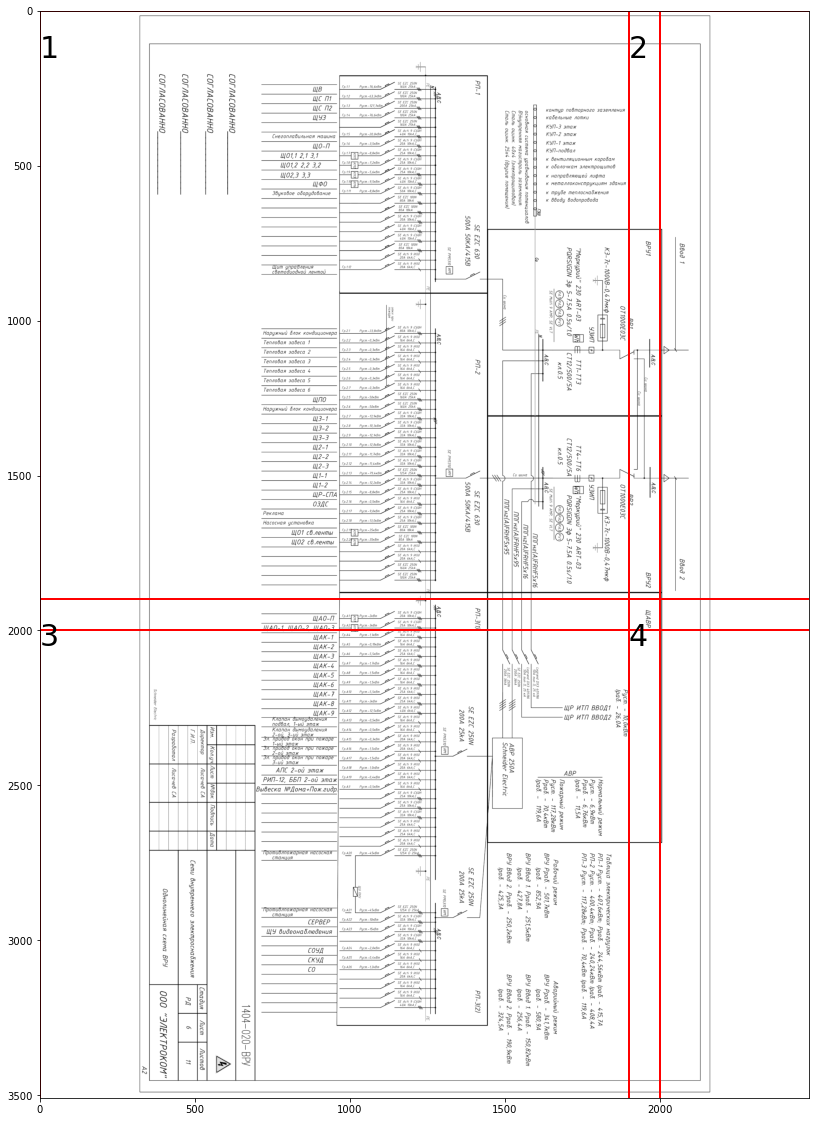

In [13]:
sep_coords = generate_separation_coordinates(image.shape, (2000, 2000), (100, 100))
plot_separation_results(image_copy, sep_coords)

**Read dataset**

In [14]:
import numpy as np
import json

with open('E:/Peter/Scheme/datasets/18-04-247-00-ss.json', 'r+') as file:
    data = json.load(file)

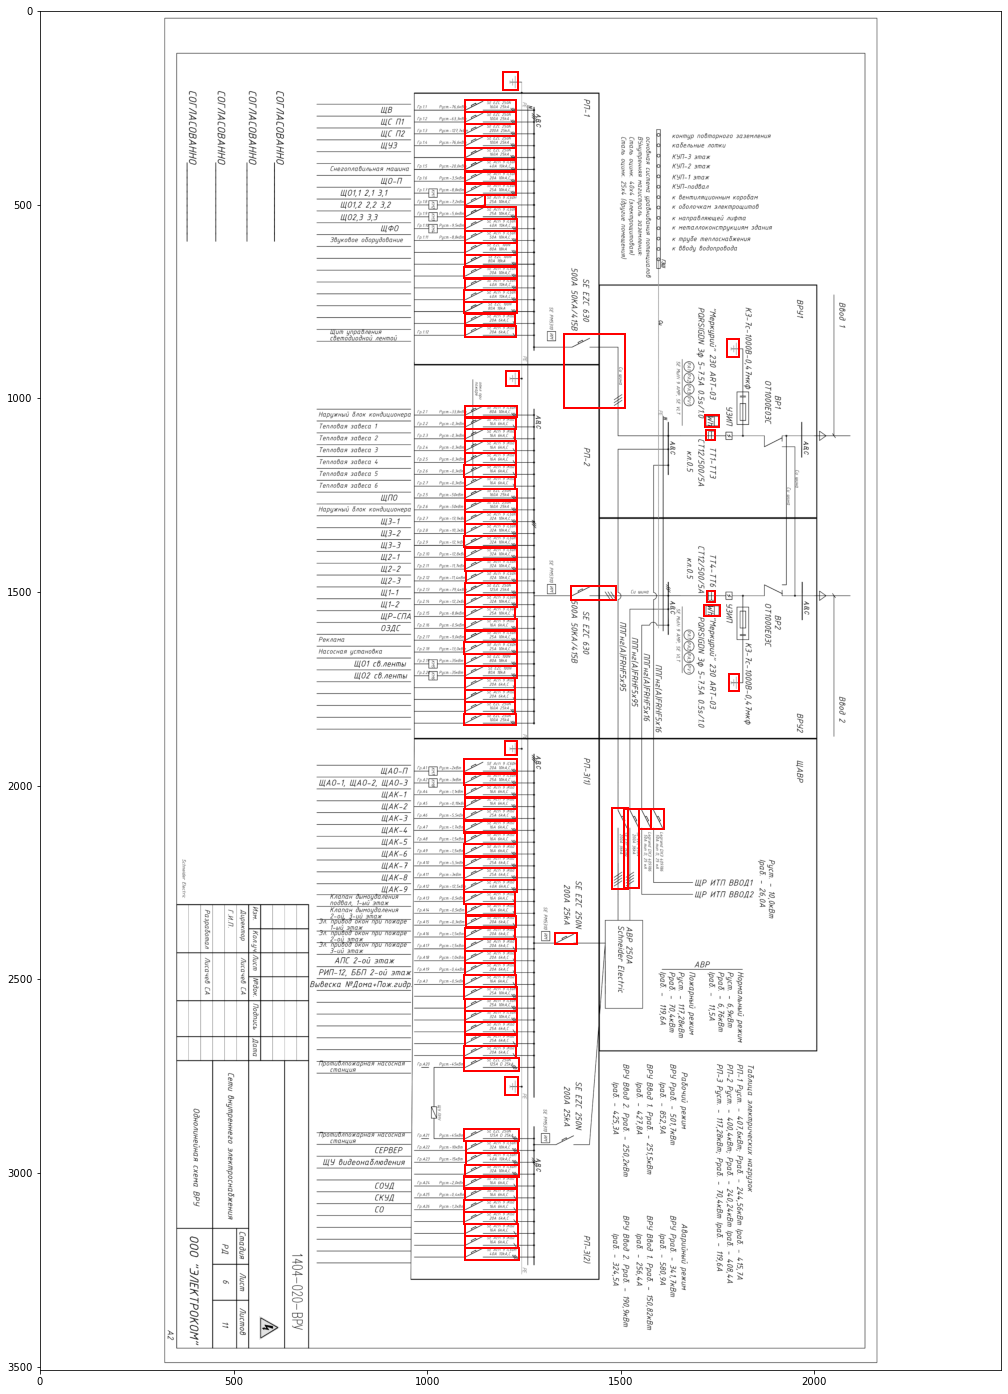

In [21]:
plot_annotations(data, 6, 'E:/Peter/Scheme/scheme_copy/')

In [ ]:
from PIL import Image
import os

image_dict = get_image_by_id(data['images'], 191)
image = np.array(Image.open(os.path.join('E:/Peter/Scheme/scheme_copy', image_dict['file_name'])))
separation_coordinates = generate_separation_coordinates(image.shape, (2000, 2000), (500, 500))
separated_annotations = separate_annotations(separation_coordinates, get_annotations_by_image_id(data['annotations'], 191))

In [ ]:
plot_separation_results(image, separation_coordinates)

In [ ]:
res = 0

for image in data['images']:
    res += len(get_annotations_by_image_id(data['annotations'], image['id']))
print(res, len(data['annotations']))